<a href="https://colab.research.google.com/github/ThaoPham96/DeepARV/blob/main/DeepARV_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up


In [1]:
pip install tensorboard

In [2]:
import tensorflow as tf
import keras
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import math
import tensorflow.experimental.numpy as tnp
import timeit
import datetime, os
import pandas as pd
import numpy as np

In [3]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report
import keras
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
import math
import tensorflow.experimental.numpy as tnp
import timeit
import datetime, os

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#Load data

In [9]:
# Loading training dataset
  ## n = 23,318
  ## X represents drug pair between 34 ARV and 695 comedication
  ## y represents DDI classification
X_train = np.load('/content/drive/MyDrive/liverpool_hiv/Cleaning_data/numpy_array/X_train_concat.npy')
y_train = np.load('/content/drive/MyDrive/liverpool_hiv/Cleaning_data/numpy_array/Y_train_full.npy')

In [10]:
# Loading testing dataset (8 untrained ARV and 695 comedication)
  ## n = 5824 drug pairs
  ## X represents drug pair between ARV and comedication
  ## y represents DDI classification
X_test = np.load('/content/drive/MyDrive/liverpool_hiv/Cleaning_data/numpy_array/X_test_concat.npy')
y_test = np.load('/content/drive/MyDrive/liverpool_hiv/Cleaning_data/numpy_array/Y_test_full.npy')

In [11]:
# Distribution of DDI class in the training set
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)
# DDI risks:
  ## 0 = Green: No DDI expected
  ## 1 = Yellow: Potential interaction of weak clinical relevance
  ## 2 = Amber: Potential clinically relevant interaction
  ## 3 = Red: These drugs should not be co-administered

[[    0 16745]
 [    1  1782]
 [    2  3728]
 [    3  1063]]


In [12]:
# Distribution of DDI class in the testing set
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)
# DDI risks:
  ## 0 = Green: No DDI expected
  ## 1 = Yellow: Potential interaction of weak clinical relevance
  ## 2 = Amber: Potential clinically relevant interaction
  ## 3 = Red: These drugs should not be co-administered

[[   0 3740]
 [   1  416]
 [   2 1234]
 [   3  434]]


#Function

###Confusion matrix

In [13]:
#This function plots confusion matrix

def plot_confusion_matrix(cf_matrix,
                          x_class_labels, y_class_labels,
                          axis_x_title,axis_y_title):

    cf_matrix = np.array(cf_matrix)
    group_counts = [value for value in cf_matrix.flatten()]
    labels = [f"{v1}"
              for v1 in
              group_counts]
    labels= np.asarray(labels).reshape(len(cf_matrix),
                                       len(cf_matrix))
    sns.set(font_scale=1)
    from matplotlib import pyplot
    pyplot.figure(
                  figsize=(5, 2),
                  dpi=150
                  ) # width and height in inches
    res = sns.heatmap(
                      cf_matrix, annot=labels,
                      fmt='', annot_kws={'size': 11.5},
                      cmap='Blues',
                      xticklabels = x_class_labels,
                      yticklabels = y_class_labels
                      )
    res.set_xticklabels(
                        res.get_xmajorticklabels(),
                        fontsize = 10.5
                        )
    res.set_yticklabels(
                        res.get_ymajorticklabels(),
                        fontsize = 10.5
                        )
    plt.xlabel(axis_x_title, size=11,fontweight='bold')
    plt.ylabel(axis_y_title, size=11,fontweight='bold')

In [14]:
#This function plots heatmap
#for a given confusion matrix
        #require: confusion matrix,
        #...classes for x and y axis,
        #...and title label for x and y axis

def plot_normalised_cf(cf_matrix,
                          x_class_labels, y_class_labels,
                          axis_x_title,axis_y_title):

    #cf_matrix = np.array(cf_matrix)
    cf_matrix_cal = np.array(cf_matrix)/np.sum(cf_matrix,axis=1)[:,np.newaxis]
    cf_matrix_normalised = np.around(cf_matrix_cal,2)
    group_counts = [value for value in cf_matrix_normalised.flatten()]
    labels = [f"{v1}"
              for v1 in
              group_counts]
    labels= np.asarray(labels).reshape(len(cf_matrix_normalised),
                                       len(cf_matrix_normalised))
    sns.set(font_scale=1)
    from matplotlib import pyplot
    pyplot.figure(
                  figsize=(5, 2),
                  dpi=150
                  ) # width and height in inches
    res = sns.heatmap(
                      cf_matrix_normalised, annot=labels,
                      fmt='', annot_kws={'size': 11.5},
                      cmap='Purples',
                      xticklabels = x_class_labels,
                      yticklabels = y_class_labels
                      )
    res.set_xticklabels(
                        res.get_xmajorticklabels(),
                        fontsize = 10.5
                        )
    res.set_yticklabels(
                        res.get_ymajorticklabels(),
                        fontsize = 10.5
                        )
    plt.xlabel(axis_x_title, size=11,fontweight='bold')
    plt.ylabel(axis_y_title, size=11,fontweight='bold')

###Metric for each class

In [15]:
#This function calculates true negative (tn),
    #false positive (fp), false negative (fn),
    #and true positive (tp) for each DDI class
    #returns: accuracy, precision, sensitivity,
    #specificity, f1 score and balanced accuracy

def metrics_func(matrix):
  tn = matrix[0][0]
  fp = matrix[1][0]
  fn = matrix[0][1]
  tp = matrix[1][1]

  accuracy = (tp+tn)/(tp+tn+fp+fn)
  precision = tp/(tp+fp)
  specificity = tn/(tn+fp)
  sensitivity = tp/(tp+fn)
  f1_score = (2*((precision*sensitivity) /
                   (precision+sensitivity)))
  BAcc = (sensitivity + specificity) / 2
  return accuracy, precision, sensitivity, specificity, f1_score, BAcc

#Evaluation




In [16]:
# Load trained DeepARV model (5 ensembles)
model_trained = {}
model_trained[0] = tf.keras.models.load_model('/content/drive/MyDrive/liverpool_hiv/Trained_Models/DeepARV_v1/DeepARV_model0')
model_trained[1] = tf.keras.models.load_model('/content/drive/MyDrive/liverpool_hiv/Trained_Models/DeepARV_v1/DeepARV_model1')
model_trained[2] = tf.keras.models.load_model('/content/drive/MyDrive/liverpool_hiv/Trained_Models/DeepARV_v1/DeepARV_model2')
model_trained[3] = tf.keras.models.load_model('/content/drive/MyDrive/liverpool_hiv/Trained_Models/DeepARV_v1/DeepARV_model3')
model_trained[4] = tf.keras.models.load_model('/content/drive/MyDrive/liverpool_hiv/Trained_Models/DeepARV_v1/DeepARV_model4')


In [18]:
# Performance on test set

## dict containing all results
all_results = {}
##dict containing results from single ensemble
temp_results = {}
for i in range(5):
    #make prediction
    #iterate through each ensemble
    all_results[i] = model_trained[i].predict(X_test)

    #store each final class prediction per model in temp dict
    class_pred = []
    ##loop through each prediction and get the class prediction
    for j in all_results[i]:
        max = np.argmax(j)
        class_pred.append(max)
    temp_results[i] = class_pred

# Vote max
df_vote_v2 = pd.DataFrame(data=temp_results)
df_vote_v2[['final_vote_A','final_vote_B']] = df_vote_v2.mode(axis=1)
final_vote = []
for i in range(len(df_vote_v2)):
  if np.isnan(df_vote_v2['final_vote_B'].iloc[i]) == True:
    final_vote.append(int(df_vote_v2['final_vote_A'].iloc[i]))
  if np.isnan(df_vote_v2['final_vote_B'].iloc[i]) != True:
    final_vote.append(int(df_vote_v2['final_vote_B'].iloc[i]))
df_vote_v2['final_vote'] = final_vote

y_p_ohe = tf.keras.utils.to_categorical(df_vote_v2.final_vote)
y_t_ohe = tf.keras.utils.to_categorical(y_test)
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=4)
metric.update_state(y_p_ohe, y_t_ohe)
result = metric.result()
result = result.numpy()
class_0 = metrics_func(result[0])
class_1 = metrics_func(result[1])
class_2 = metrics_func(result[2])
class_3 = metrics_func(result[3])

# Macro metrics
#accuracy, precision,  sensitivity, specificity, f1_score, BAcc
macro = np.mean((class_0, class_1, class_2, class_3), axis=0)
macros = macro.reshape(1,-1)
each_class_results = np.vstack((class_0,class_1,class_2,class_3,macros))



#Print out result table
df_hold = pd.DataFrame(columns =['Accuracy','Precision','Sensitivity',
                               'Specificity','F1_score', 'Balanced Accuracy'],
                       index=['Green','Yellow','Amber','Red','Macro'],
                       data = each_class_results)
df_hold


182/182 [==============================] - 0s 2ms/step


,Accuracy,Precision,Sensitivity,Specificity,F1_score,Balanced Accuracy
Green,0.688702,0.914409,0.568449,0.904511,0.701072,0.736480
Yellow,0.842033,0.253425,0.622596,0.858913,0.360223,0.740754
Amber,0.712054,0.387734,0.619935,0.736819,0.477081,0.678377
Red,0.916209,0.446429,0.518433,0.948237,0.479744,0.733335
Macro,0.789749,0.500499,0.582353,0.862120,0.504530,0.722237


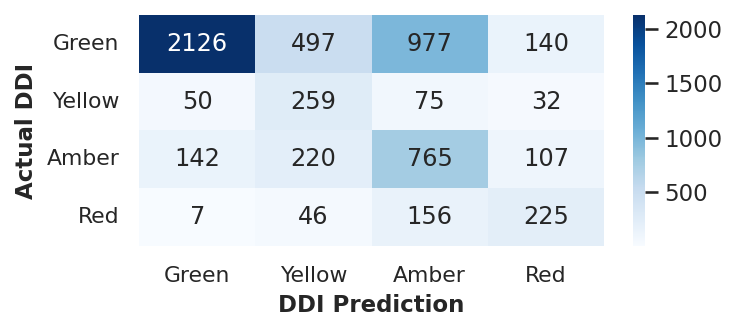

In [19]:
# confusion matrix
confusion_matrix_com = tf.math.confusion_matrix(y_test,df_vote_v2.final_vote, 4)

# heatmap for confusion matrix
plot_confusion_matrix(confusion_matrix_com,
                      ['Green','Yellow','Amber','Red'],
                      ['Green','Yellow','Amber','Red'],'DDI Prediction','Actual DDI')

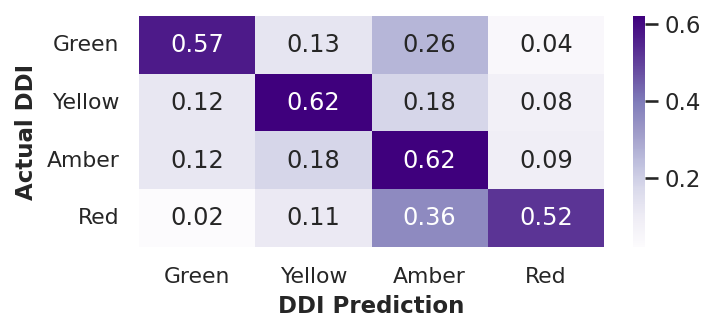

In [20]:
# Normalised confusion matrix of distributed DDI prediction versus
## the true DDI on the test set of 5,824 drug pairs.
plot_normalised_cf(confusion_matrix_com,
                   ['Green','Yellow','Amber','Red'],
                   ['Green','Yellow','Amber','Red'],
                   'DDI Prediction','Actual DDI')

#Classical ML

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
for Model in [GaussianNB, KNeighborsClassifier, LinearSVC]:
    clf = Model().fit(X_train, y_train)
    y_pred_classic = clf.predict(X_test)
    print(y_pred_classic)
    print('f1-score','%s' %
          (
           metrics.f1_score(y_test, y_pred_classic, average='weighted')))
    print('balanced accuracy','%s: %s' %
          (Model.__name__,
           metrics.balanced_accuracy_score(y_test, y_pred_classic)))
    print('accuracy','%s: %s' %
          (Model.__name__,
           metrics.accuracy_score(y_test, y_pred_classic)))
    print('------')

[0 1 1 ... 3 1 3]
f1-score 0.5988462318801717
balanced accuracy GaussianNB: 0.6107334694435927
accuracy GaussianNB: 0.5662774725274725
------
[0 0 0 ... 1 0 1]
f1-score 0.7755920339902195
balanced accuracy KNeighborsClassifier: 0.6176950415398327
accuracy KNeighborsClassifier: 0.7841689560439561
------
[0 1 0 ... 3 0 1]
f1-score 0.70364208077332
balanced accuracy LinearSVC: 0.47399134617427724
accuracy LinearSVC: 0.7417582417582418
------
